In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data_transforms ={
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ]),
   'val': transforms.Compose([transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                                           }
data_dir='/home/ubuntu/dataset/hymenoptera_data/'
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) 
                            for x in ['train', 'val']}
dataloaders={x: torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4)
             for x in ['train','val']}
data_sizes={x: len(image_datasets[x]) for x in ['train','val']}
class_name=image_datasets['train'].classes
gpu=torch.cuda.is_available()

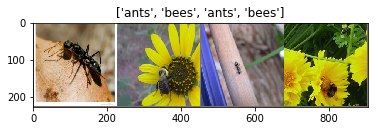

In [3]:
def imshow(inp,title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs,classes=next(iter(dataloaders['train']))
out=torchvision.utils.make_grid(inputs)
imshow(out,title=[class_name[x] for x in classes])
    
    

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since=time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc=0.0
   
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train','val']:
            running_loss=0
            running_correct=0
            if phase is 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            for data in dataloaders[phase]: 
                inputs,labels=data
                if gpu:
                    inputs=Variable(inputs.cuda())
                    labels=Variable(labels.cuda())
                else:
                    inputs=Variable(inputs)
                    labels=Variable(labels)
                optimizer.zero_grad()    
                outputs = model(inputs)
                _, preds= torch.max(outputs.data,1)
                loss=criterion(outputs,labels)
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                running_loss+=loss.data[0]*inputs.size(0)
                running_correct+=torch.sum(preds==labels.data)
            epoch_loss=running_loss/data_sizes[phase]
            epoch_acc=running_correct/data_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
            

In [15]:
def visualize_model(model,num_images=6):
    was_training=model.training
    model.eval()
    images_so_far=0
    fig=plt.figure()
    for i,data in enumerate(dataloaders['val']):
        inputs,labels=data
        if gpu:
            inputs=Variable(inputs.cuda())
            labels=Variable(labels.cuda())
        else:
            inputs,labels=Variable(inputs),Variable(labels)
        output=model(inputs)
        _,preds=torch.max(output.data,1)
        for j in range(inputs.size()[0]):
            images_so_far+=1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_name[preds[j]]))
            imshow(inputs.cpu().data[j])
            if images_so_far==num_images:
                model.train(was_training)
                return
    model.train(mode=was_training)           

In [10]:
model_ft=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_ftrs,2)
if gpu:
    model_ft = model_ft.cuda()
criterion=nn.CrossEntropyLoss()
optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft=train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6475 Acc: 0.6762
val Loss: 0.2763 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.6519 Acc: 0.7254
val Loss: 0.3096 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4814 Acc: 0.7992
val Loss: 0.2949 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.5335 Acc: 0.7664
val Loss: 0.1959 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.5632 Acc: 0.7746
val Loss: 0.4534 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.5079 Acc: 0.8115
val Loss: 0.4430 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.3635 Acc: 0.8156
val Loss: 0.2652 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3865 Acc: 0.8607
val Loss: 0.2695 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3162 Acc: 0.8770
val Loss: 0.2296 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2056 Acc: 0.9221
val Loss: 0.2365 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3522 Acc: 0.8484
val Loss: 0.2493 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2606 Acc: 0.8975
val Loss: 0.2465 Acc: 0.9150

Ep

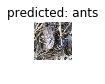

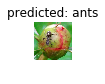

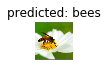

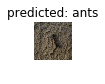

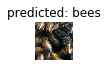

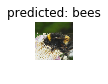

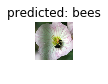

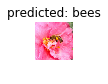

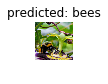

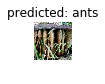

In [17]:
visualize_model(model_ft,num_images=10)

In [22]:
model_conv=torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad=False
num_ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(num_ftrs,2)
if gpu:
    model_conv.cuda()
criterion=nn.CrossEntropyLoss()
optimizer_conv=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)

In [24]:
model_conv=train_model(model_conv,criterion,optimizer_conv,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6577 Acc: 0.6516
val Loss: 0.2710 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5884 Acc: 0.7377
val Loss: 0.2289 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4991 Acc: 0.7705
val Loss: 0.1846 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4236 Acc: 0.8033
val Loss: 0.2000 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3969 Acc: 0.8484
val Loss: 0.3187 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.3923 Acc: 0.8156
val Loss: 0.1725 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3579 Acc: 0.8402
val Loss: 0.1770 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3204 Acc: 0.8484
val Loss: 0.1676 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3305 Acc: 0.8525
val Loss: 0.1837 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2903 Acc: 0.8566
val Loss: 0.2196 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2755 Acc: 0.8893
val Loss: 0.1746 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3163 Acc: 0.8607
val Loss: 0.1922 Acc: 0.9412

Ep

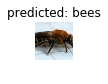

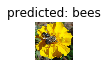

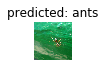

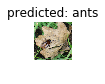

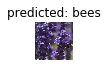

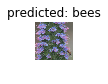

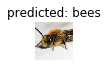

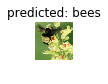

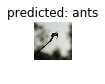

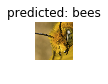

In [25]:
visualize_model(model_conv,num_images=10)
plt.ioff()
plt.show()